In [ ]:
import os

os.getcwd()

In [2]:
from tqdm import tqdm
#from skimage.transform import rotate
from scipy.spatial.transform import Rotation as R
import numpy as np

from sklearn.metrics.pairwise import euclidean_distances
#import torch.nn.functional as F
import networkx as nx
import torch
from skimage.data import shepp_logan_phantom
from skimage.transform import  rescale, radon, iradon
from skimage.morphology import disk
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import numpy as np
#from FBB import FBBasis2D
from scipy import sparse
from scipy.sparse.linalg import eigsh
from tqdm import tqdm
from skimage.transform import rotate
from scipy.spatial.transform import Rotation as R
import sys
#import plotly.graph_objects as go
sys.path.insert(0, '..')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import torch

from scipy import sparse
from scipy.sparse.linalg import eigsh
from tqdm import tqdm
from skimage.transform import rotate
from scipy.spatial.transform import Rotation as R
import sys


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
def rotation3d(d3_points,phi,psi,theta):
    r = R.from_euler('xyz', [phi, psi, theta], degrees=True)
    return r.apply(d3_points)

def inplane_distance_points(dataset,M=100):
    print('search one')
    N=dataset.shape[0]
    data2d=torch.tensor(dataset,dtype=torch.float32)


    theta=torch.arange(0,2*np.pi,2*np.pi/M)
    rot_matrix=torch.empty(M,2,2)
    rot_matrix[:,0,0]=torch.cos(theta)
    rot_matrix[:,0,1]=-torch.sin(theta)
    rot_matrix[:,1,0]=torch.sin(theta)
    rot_matrix[:,1,1]=torch.cos(theta)

    distance_matrix=torch.empty((N,N))
    angle_matrix=torch.empty((N,N))
    for i in tqdm(range(N)):
        pts2dI=data2d[i,:,:]
        pts2dI_bt=torch.broadcast_to(pts2dI,(data2d.shape[0],M,data2d.shape[1],data2d.shape[2]))
        pts2d_rot=torch.einsum('nzp,mpq->nmzq', data2d, rot_matrix)
        diff=torch.norm(pts2d_rot-pts2dI_bt,dim=(2,3))
        diff,min_index=torch.min(diff,dim=1)
        distance_matrix[i,:]=diff
        angle_matrix[i]=theta[min_index]
    return distance_matrix.numpy(),angle_matrix.numpy()


def get_img(d3_points,resolution=50,xlim=[-1,1],ylim=[-1,1],theta=None,block=False):
    [xlim_l,xlim_u]=xlim
    [ylim_l,ylim_u]=ylim
    devx=(xlim_u-xlim_l)/resolution
    devy=(ylim_u-ylim_l)/resolution
    data_2d=d3_points[:,:2]
    if theta is not None:
        rot_matrix=np.empty((2,2))
        rot_matrix[0,0]=np.cos(theta)
        rot_matrix[0,1]=-np.sin(theta)
        rot_matrix[1,0]=np.sin(theta)
        rot_matrix[1,1]=np.cos(theta)
        data_2d=data_2d@rot_matrix
    data_2d=data_2d.T


    xcord=(data_2d[0,:]-(xlim_l))/devx
    ycord=(data_2d[1,:]-(ylim_l))/devy


    xcord[xcord>=resolution]=resolution-1
    xcord[ycord>=resolution]=resolution-1
    xcord[xcord<0]=0
    ycord[ycord<0]=0


    xcord=torch.tensor(xcord,dtype=torch.long)
    ycord=torch.tensor(ycord,dtype=torch.long)
    z=torch.ones_like(xcord,dtype=torch.int)
    img=torch.zeros((resolution,resolution),dtype=torch.int)
    img.index_put_((xcord, ycord), z, accumulate=True)
    img=img.numpy()
    if block:
        img[img>0]=1
    return img

def get_img_3d(d3_points,resolution=50,xlim=[-1,1],ylim=[-1,1],zlim=[-1,1],theta=None,block=False):
    [xlim_l,xlim_u]=xlim
    [ylim_l,ylim_u]=ylim
    [zlim_l,zlim_u]=zlim
    devx=(xlim_u-xlim_l)/resolution
    devy=(ylim_u-ylim_l)/resolution
    devz=(ylim_u-ylim_l)/resolution
    data_3d=d3_points.T



    xcord=(data_3d[0,:]-(xlim_l))/devx
    ycord=(data_3d[1,:]-(ylim_l))/devy
    zcord=(data_3d[2,:]-(zlim_l))/devz



    xcord[xcord>=resolution]=resolution-1
    xcord[ycord>=resolution]=resolution-1
    zcord[zcord>=resolution]=resolution-1
    xcord[xcord<0]=0
    ycord[ycord<0]=0
    zcord[zcord<0]=0


    xcord=torch.tensor(xcord,dtype=torch.long)
    ycord=torch.tensor(ycord,dtype=torch.long)
    zcord=torch.tensor(zcord,dtype=torch.long)
    z=torch.ones_like(xcord,dtype=torch.int)
    img=torch.zeros((resolution,resolution,resolution),dtype=torch.int)
    img.index_put_((xcord, ycord,zcord), z, accumulate=True)
    img=img.numpy()
    if block:
        img[img>0]=1
    return img

In [6]:
pts=np.load("maps/bunny.npy")
pts=pts[np.random.permutation(pts.shape[0]),:]

resolution = 50

pts[:,0]=pts[:,0]-(pts[:,0].max()+pts[:,0].min())/2
pts[:,1]=pts[:,1]-(pts[:,1].max()+pts[:,1].min())/2
pts[:,2]=pts[:,2]-(pts[:,2].max()+pts[:,2].min())/2
pts_max=np.linalg.norm(pts,axis=1).max()
pts=pts/pts_max

V=get_img_3d(pts,resolution=resolution,block=True)
V.shape
V.dtype
print(V)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [7]:
import matplotlib.pyplot as plt
from utils.Vedo import *

embedWindow(verbose=True): could not load ipyvtklink try:
> pip install ipyvtklink


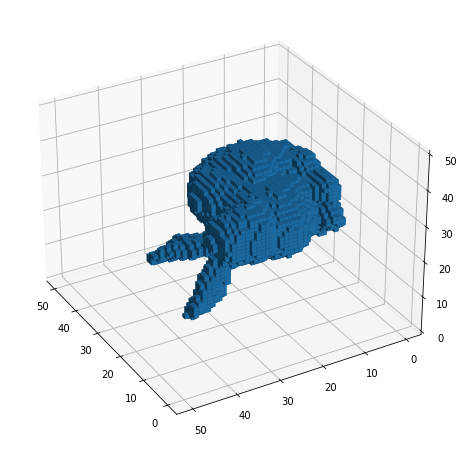

In [8]:
plt.rcParams["figure.figsize"] = (12,8)
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(V)
ax.view_init(30, 150)
plt.show()

In [9]:
print(V.max())
print(V.min())
print(V.mean())

1
0
0.029984


In [ ]:
import numpy as np
import logging


from aspire.volume import Volume

from utils.Data import *
from utils.AspireHelpers import *
from utils.Plotting import *
import time
import mrcfile

from utils.Plotting import plot_voxels

logger = logging.getLogger(__name__)



aspire_vol = Volume(V)


img_size = 100  # image size in square
n_img = 1000  # number of images
snr = 10
K = 10

aspire_vol, sim, clean_graph, noisy_graph = reconstruct_result_cheng(V, n_img, img_size, snr, K)

A = create_adj_mat_nx(clean_graph.classes)

embedding = calc_graph_laplacian(A, numberOfEvecs=3)
embedding_normalized = normalize_min_max(embedding)

plot_3dscatter(embedding_normalized[:,0], embedding_normalized[:,1], embedding_normalized[:,2])

embedding_normalized = align_3d_embedding_to_shpere(embedding_normalized)

plot_3dscatter(embedding_normalized[:,0], embedding_normalized[:,1], embedding_normalized[:,2])

rots = calc_rotation_from_points_on_sphere(embedding_normalized)

clean_images = sim.images(0, n_img).asnumpy()
rec_calculated_rots = reconstruction_naive(clean_images, n_img, img_size, rots)
#rec_given_rots = reconstruction_naive(clean_images, n_img, img_size, sim.angles)


voxelSaveAsMap(rec_calculated_rots, 'rec_calculated_rots_2.map')
#voxelSaveAsMap(rec_calculated_rots, 'rec_given_rots.map')
